# BERT Fine-Tuning Tutorial with PyTorch

By Chris McCormick and Nick Ryan

*Revised on 12/13/19 to use the new [transformers](https://github.com/huggingface/transformers) interface.*




## 1.1. Using Colab GPU for Training



Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)`

Then run the following cell to confirm that the GPU is detected.

In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

/new-stg/home/banghua/anaconda3/envs/LLM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


There are 1 GPU(s) available.
We will use the GPU: NVIDIA RTX A6000


## 1.2. Installing the Hugging Face Library



Next, let's install the [transformers](https://github.com/huggingface/transformers) package from Hugging Face which will give us a pytorch interface for working with BERT. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2.) We've selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don't provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow, when the purpose here is BERT!).

At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with BERT. In addition to supporting a variety of different pre-trained transformer models, the library also includes pre-built modifications of these models suited to your specific task. For example, in this tutorial we will use `BertForSequenceClassification`.

The library also includes task-specific classes for token classification, question answering, next sentence prediciton, etc. Using these pre-built classes simplifies the process of modifying BERT for your purposes.


The code in this notebook is actually a simplified version of the [run_glue.py](https://github.com/huggingface/transformers/blob/master/examples/run_glue.py) example script from huggingface.

`run_glue.py` is a helpful utility which allows you to pick which GLUE benchmark task you want to run on, and which pre-trained model you want to use (you can see the list of possible models [here](https://github.com/huggingface/transformers/blob/e6cff60b4cbc1158fbd6e4a1c3afda8dc224f566/examples/run_glue.py#L69)). It also supports using either the CPU, a single GPU, or multiple GPUs. It even supports using 16-bit precision if you want further speed up.

Unfortunately, all of this configurability comes at the cost of *readability*. In this Notebook, we've simplified the code greatly and added plenty of comments to make it clear what's going on.

# 2. Loading CoLA Dataset


## 2.2. Parse

We can see from the file names that both `tokenized` and `raw` versions of the data are available.

We can't use the pre-tokenized version because, in order to apply the pre-trained BERT, we *must* use the tokenizer provided by the model. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

We'll use pandas to parse the "in-domain" training set and look at a few of its properties and data points.

In [6]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df_train = pd.read_csv("~/med264/Dataset1/day1_30mortality_train.csv", index_col=0)
num_train_pos = df_train[df_train['Label'] == 1].shape[0]
num_train_neg = df_train[df_train['Label'] == 0].shape[0]
num_balanced = min(num_train_pos, num_train_neg)
df_train_pos = df_train[df_train['Label'] == 1].sample(n=num_balanced, random_state=42)
df_train_neg = df_train[df_train['Label'] == 0].sample(n=num_balanced, random_state=42)
df_train = pd.concat([df_train_pos, df_train_neg])

df_val = pd.read_csv("~/med264/Dataset1/day1_30mortality_val.csv", index_col=0)
num_val_pos = df_val[df_val['Label'] == 1].shape[0]
num_val_neg = df_val[df_val['Label'] == 0].shape[0]
num_balanced = min(num_val_pos, num_val_neg)
df_val_pos = df_val[df_val['Label'] == 1].sample(n=num_balanced, random_state=42)
df_val_neg = df_val[df_val['Label'] == 0].sample(n=num_balanced, random_state=42)
df_val = pd.concat([df_val_pos, df_val_neg])

df_test = pd.read_csv("~/med264/Dataset1/day1_30mortality_test.csv", index_col=0)
num_test_pos = df_test[df_test['Label'] == 1].shape[0]
num_test_neg = df_test[df_test['Label'] == 0].shape[0]
num_balanced = min(num_test_pos, num_test_neg)
df_test_pos = df_test[df_test['Label'] == 1].sample(n=num_balanced, random_state=42)
df_test_neg = df_test[df_test['Label'] == 0].sample(n=num_balanced, random_state=42)
df_test = pd.concat([df_test_pos, df_test_neg])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df_train.shape[0]))
print('Number of validation sentences: {:,}\n'.format(df_val.shape[0]))
print('Number of testing sentences: {:,}\n'.format(df_test.shape[0]))

Number of training sentences: 26,108

Number of validation sentences: 3,100

Number of testing sentences: 3,246



In [7]:
# Get the lists of sentences and their labels.
sentences_train = df_train.TEXT.values
labels_train = df_train.Label.values
sentences_val = df_val.TEXT.values
labels_val = df_val.Label.values
sentences_test = df_test.TEXT.values
labels_test = df_test.Label.values

# 3. Tokenization & Input Formatting

In this section, we'll transform our dataset into the format that BERT can be trained on.

## 3.1. BERT Tokenizer


To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.


In [8]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('medicalai/ClinicalBERT', do_lower_case=True)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


Loading BERT tokenizer...


Let's apply the tokenizer to one sentence just to see the output.


In [9]:
# Print the original sentence.
print(' Original: ', sentences_train[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences_train[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences_train[0])))

 Original:  throughout the aorta. there is no hilar, mediastinal, or axillary lymphadenopathy. ct of the abdomen with iv contrast: ng tube is noted within the stomach. the adrenal glands, pancreas, gallbladder, and liver are within normal limits. there is a small splenic cyst near the splenic hilum. the kidneys are shrunken and atrophic bilaterally. multiple cysts are noted with the largest in the right kidney measuring up to 6 cm. there is no retroperitoneal or mesenteric lymphadenopathy. there is no free air or free fluid. (over) 1:44 pm cta chest w&w/o c&recons, non-coronary; ct abdomen w/contrast clip # ct pelvis w/contrast reason: r/o pe final report (cont) ct of the pelvis with iv contrast: the rectum and sigmoid colon are abnormal with wall thickening, adjacent fat stranding, and relative of the wall. the remainder of the bowel wall appears within normal limits. there is no evidence of obstruction. the abdominal and pelvic arterial vasculature is heavily calcified. however, ther

When we actually convert all of our sentences, we'll use the `tokenize.encode` function to handle both steps, rather than calling `tokenize` and `convert_tokens_to_ids` separately.

Before we can do that, though, we need to talk about some of BERT's formatting requirements.

## 3.2. Sentences to IDs

The `tokenizer.encode` function combines multiple steps for us:
1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.

Oddly, this function can perform truncating for us, but doesn't handle padding.

In [10]:
from tqdm import tqdm
import os
import pickle

# Correct the path by expanding the tilde to the user's home directory
file_path_train = os.path.expanduser('~/med264/Dataset2/input_ids_train.pickle')
file_path_valid = os.path.expanduser('~/med264/Dataset2/input_ids_valid.pickle')
file_path_test = os.path.expanduser('~/med264/Dataset2/input_ids_test.pickle')


input_ids_train, input_ids_valid, input_ids_test = [], [], []

if os.path.exists(file_path_train):
    with open(file_path_train, 'rb') as f:
        input_ids_train = pickle.load(f)
    print('Loaded input_ids_train.')
else:
    for sent in tqdm(sentences_train):
        encoded_sent = tokenizer.encode(sent, add_special_tokens = True)
        input_ids_train.append(encoded_sent)
    with open(file_path_train, 'wb') as f:
        pickle.dump(input_ids_train, f)
    print('Saved input_ids_train.')


if os.path.exists(file_path_valid):
    with open(file_path_valid, 'rb') as f:
        input_ids_valid = pickle.load(f)
    print('Loaded input_ids_valid.')
else:
    for sent in tqdm(sentences_val):
        encoded_sent = tokenizer.encode(sent, add_special_tokens = True)
        input_ids_valid.append(encoded_sent)
    with open(file_path_valid, 'wb') as f:
        pickle.dump(input_ids_valid, f)
    print('Saved input_ids_valid.')

if os.path.exists(file_path_test):
    with open(file_path_test, 'rb') as f:
        input_ids_test = pickle.load(f)
    print('Loaded input_ids_test.')
else:
    for sent in tqdm(sentences_test):
        encoded_sent = tokenizer.encode(sent, add_special_tokens = True)
        input_ids_test.append(encoded_sent)
    with open(file_path_test, 'wb') as f:
            pickle.dump(input_ids_test, f)
    print('Saved input_ids_test.')
    

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences_train[0])
print('Token IDs:', input_ids_train[0])

100%|██████████████████████████████████████████████████████████████████████████| 26108/26108 [01:43<00:00, 251.97it/s]


Saved input_ids_train.


100%|████████████████████████████████████████████████████████████████████████████| 3100/3100 [00:11<00:00, 262.24it/s]


Saved input_ids_valid.


100%|████████████████████████████████████████████████████████████████████████████| 3246/3246 [00:14<00:00, 225.01it/s]


Saved input_ids_test.
Original:  throughout the aorta. there is no hilar, mediastinal, or axillary lymphadenopathy. ct of the abdomen with iv contrast: ng tube is noted within the stomach. the adrenal glands, pancreas, gallbladder, and liver are within normal limits. there is a small splenic cyst near the splenic hilum. the kidneys are shrunken and atrophic bilaterally. multiple cysts are noted with the largest in the right kidney measuring up to 6 cm. there is no retroperitoneal or mesenteric lymphadenopathy. there is no free air or free fluid. (over) 1:44 pm cta chest w&w/o c&recons, non-coronary; ct abdomen w/contrast clip # ct pelvis w/contrast reason: r/o pe final report (cont) ct of the pelvis with iv contrast: the rectum and sigmoid colon are abnormal with wall thickening, adjacent fat stranding, and relative of the wall. the remainder of the bowel wall appears within normal limits. there is no evidence of obstruction. the abdominal and pelvic arterial vasculature is heavily cal

## 3.3. Padding & Truncating

Pad and truncate our sequences so that they all have the same length, `MAX_LEN`.

First, what's the maximum sentence length in our dataset?

In [11]:
print('Max train sentence length: ', max([len(sen) for sen in input_ids_train]))
print('Max valid sentence length: ', max([len(sen) for sen in input_ids_valid]))
print('Max test sentence length: ', max([len(sen) for sen in input_ids_test]))

Max train sentence length:  918
Max valid sentence length:  1123
Max test sentence length:  878


Given that, let's choose MAX_LEN = 64 and apply the padding.

In [12]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 512

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids_train = pad_sequences(input_ids_train, maxlen=MAX_LEN, dtype="long",
                          value=0, truncating="post", padding="post")
input_ids_valid = pad_sequences(input_ids_valid, maxlen=MAX_LEN, dtype="long",
                            value=0, truncating="post", padding="post")
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long",
                            value=0, truncating="post", padding="post")

print('\nDone.')

2023-11-28 01:50:04.981461: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-28 01:50:05.020124: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 01:50:05.020159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 01:50:05.021145: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 01:50:05.026778: I tensorflow/core/platform/cpu_feature_guar


Padding/truncating all sentences to 512 values...

Padding token: "[PAD]", ID: 0

Done.


## 3.4. Attention Masks

The attention mask simply makes it explicit which tokens are actual words versus which are padding.

The BERT vocabulary does not use the ID 0, so if a token ID is 0, then it's padding, and otherwise it's a real token.

In [13]:
# Create attention masks
attention_masks_train, attention_masks_valid, attention_masks_test = [], [], []

# For each sentence...
for sent in input_ids_train:

    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]

    # Store the attention mask for this sentence.
    attention_masks_train.append(att_mask)

for sent in input_ids_valid:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks_valid.append(att_mask)

for sent in input_ids_test:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks_test.append(att_mask)

## 3.5. Training & Validation Split


Divide up our training set to use 90% for training and 10% for validation.

In [14]:
train_inputs, validation_inputs, test_inpputs, train_labels, validation_labels, test_labels =\
input_ids_train, input_ids_valid, input_ids_test, labels_train, labels_val, labels_test
# Do the same for the masks.
train_masks, validation_masks, test_masks = attention_masks_train, attention_masks_valid, attention_masks_test

## 3.6. Converting to PyTorch Data Types

Our model expects PyTorch tensors rather than numpy.ndarrays, so convert all of our dataset variables.

In [15]:
# Convert all inputs and labels into torch tensors, the required datatype
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [16]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 64

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


# 4. Train Our Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model.

## 4.1. BertForSequenceClassification

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task.

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.  

Here is the current list of classes provided for fine-tuning:
* BertModel
* BertForPreTraining
* BertForMaskedLM
* BertForNextSentencePrediction
* **BertForSequenceClassification** - The one we'll use.
* BertForTokenClassification
* BertForQuestionAnswering

The documentation for these can be found under [here](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html).



We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.


OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

The documentation for `from_pretrained` can be found [here](https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained), with the additional parameters defined [here](https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig).

In [17]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "medicalai/ClinicalBERT", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at medicalai/ClinicalBERT and are newly initialized: ['encoder.layer.7.output.LayerNorm.bias', 'encoder.layer.7.attention.self.value.bias', 'encoder.layer.10.attention.self.key.bias', 'encoder.layer.6.attention.output.dense.bias', 'encoder.layer.4.output.dense.bias', 'encoder.layer.1.attention.output.dense.bias', 'encoder.layer.10.output.LayerNorm.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.5.output.dense.weight', 'encoder.layer.2.output.LayerNorm.weight', 'encoder.layer.2.output.LayerNorm.bias', 'encoder.layer.1.attention.self.key.weight', 'encoder.layer.10.intermediate.dense.weight', 'encoder.layer.10.output.dense.bias', 'encoder.layer.2.output.dense.bias', 'encoder.layer.5.attention.self.key.weight', 'encoder.layer.7.atten

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, I've printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.




In [18]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

## 4.2. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values:
- Batch size: 16, 32  (We chose 32 when creating our DataLoaders).
- Learning rate (Adam): 5e-5, 3e-5, 2e-5  (We'll use 2e-5).
- Number of epochs: 2, 3, 4  (We'll use 4).

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [19]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/new-stg/home/banghua/anaconda3/envs/LLM/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 10

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. At each pass we need to:

Training loop:
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass.
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

Evalution loop:
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

So please read carefully through the comments to get an understanding of what's happening. If you're unfamiliar with pytorch a quick look at some of their [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) will help show you that training loops really involve only a few simple steps; the rest is usually just decoration and logging.  

Define a helper function for calculating accuracy.

In [21]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times.


In [22]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


We're ready to kick off the training!

In [25]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

model_path = os.path.expanduser('~/med264/models_balanced/')
if not os.path.exists(model_path):
    os.makedirs(model_path)

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        # The call to `model` always returns a tuple, so we need to pull the
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    # Save the model
    model.save_pretrained(model_path + str(epoch_i))

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 10 ========
Training...


  Batch    40  of    408.    Elapsed: 0:00:57.
  Batch    80  of    408.    Elapsed: 0:01:55.
  Batch   120  of    408.    Elapsed: 0:02:54.
  Batch   160  of    408.    Elapsed: 0:03:52.
  Batch   200  of    408.    Elapsed: 0:04:51.
  Batch   240  of    408.    Elapsed: 0:05:50.
  Batch   280  of    408.    Elapsed: 0:06:48.
  Batch   320  of    408.    Elapsed: 0:07:47.
  Batch   360  of    408.    Elapsed: 0:08:45.
  Batch   400  of    408.    Elapsed: 0:09:44.

  Average training loss: 0.66
  Training epcoh took: 0:10:03

Running Validation...
  Accuracy: 0.58
  Validation took: 0:00:24

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    408.    Elapsed: 0:00:58.
  Batch    80  of    408.    Elapsed: 0:01:57.
  Batch   120  of    408.    Elapsed: 0:02:56.
  Batch   160  of    408.    Elapsed: 0:03:54.
  Batch   200  of    408.    Elapsed: 0:04:53.
  Batch   240  of    408.    Elapsed: 0:05:51.
  Batch   280  of    408.    Elapsed: 0:06:50.
  Batch   320  of    408.   

In [26]:
# Save loss_values
with open(model_path + 'loss_values.pickle', 'wb') as f:
    pickle.dump(loss_values, f)

Let's take a look at our training loss over all batches:

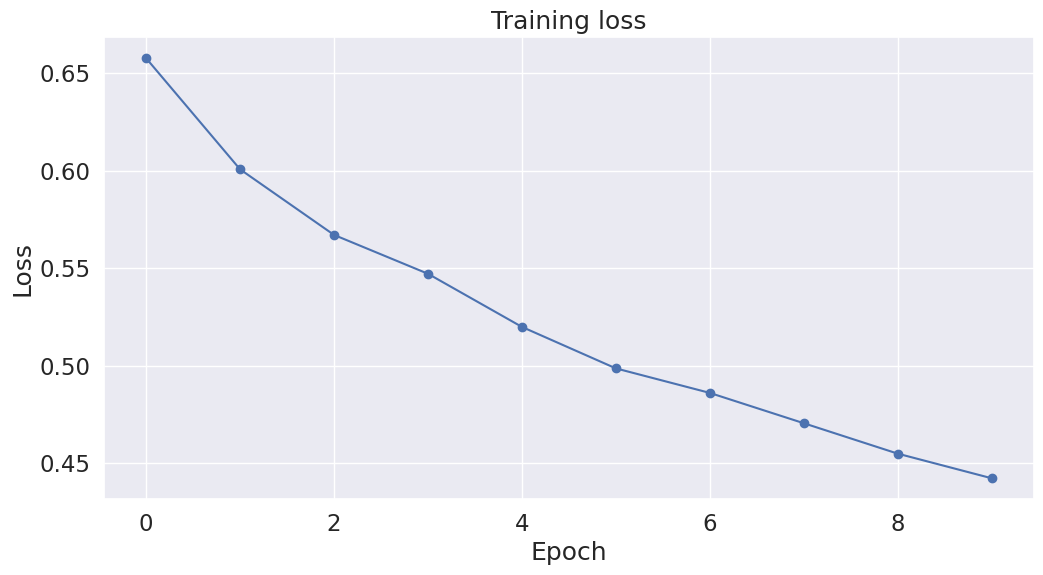

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Save the plot to file.
plt.savefig("BERT_Fine_Tuning_balanced_loss.png", dpi = 300)

plt.show()

In [26]:
# Save ipynb session
import dill
dill.dump_session('BERT_Fine_Tuning_Sentence_Classification_v2.db')